# Boston_Housing

In [1]:
import numpy as np
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import matplotlib.pyplot as plt
from scipy.stats import chi2
from sklearn.svm import SVR

## 数据预处理

- 自变量
 - RM: 每个住宅的平均房间数 (average number of rooms per dwelling)
 - LSTAT: 被认为地位较低的人口的百分比 (percentage of population considered lower status)
 - PTRATIO: 按城镇分配的学生与教师比例 (pupil-teacher ratio by town)
 
- 因变量
 - MEDV: 该房屋的价值的估值中值 (median value of owner-occupied homes)

In [2]:
df = pd.read_csv('housing.csv')   # (489, 4)
df.head()

,RM,LSTAT,PTRATIO,MEDV
0,6.575,4.98,15.3,504000.0
1,6.421,9.14,17.8,453600.0
2,7.185,4.03,17.8,728700.0
3,6.998,2.94,18.7,701400.0
4,7.147,5.33,18.7,760200.0


### 缺失值处理

In [7]:
# df.isnull()
df.isnull().any()

RM         False
LSTAT      False
PTRATIO    False
MEDV       False
dtype: bool

### 异常值处理
根据$\chi^2$分布结果可得，无异常值

#### 样本可视化
从图片中可看出变量RM和y呈正相关关系，变量LSTAT与y呈负相关关系，变量PTRATIO与y无明显关系。

Text(0.5, 0, 'RM')

Text(0, 0.5, 'MEDV')

Text(0.5, 0, 'LSTAT')

Text(0, 0.5, 'MEDV')

Text(0.5, 0, 'PTRATIO')

Text(0, 0.5, 'MEDV')

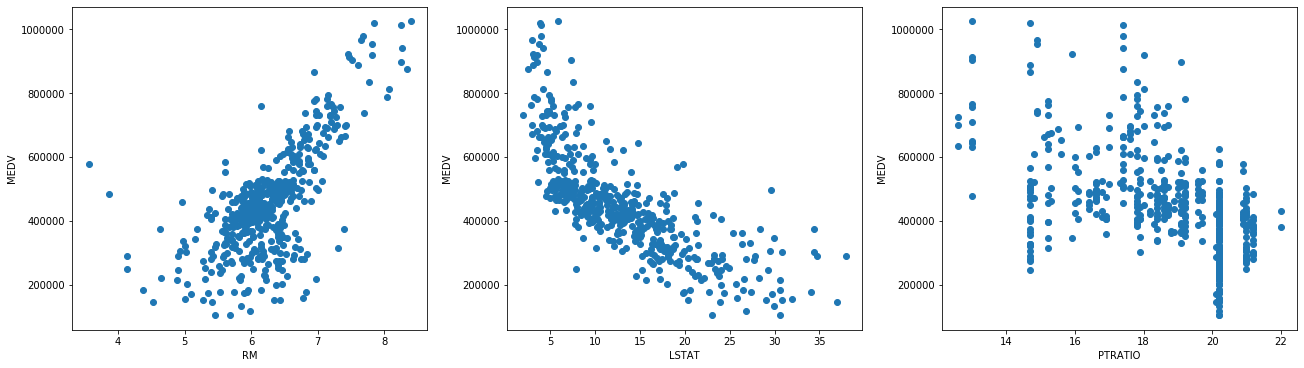

In [5]:
# fig1, f1_axes = plt.subplots(ncols=2, nrows=2, constrained_layout=True)
fig, f1_axes = plt.subplots(ncols = 3, nrows = 1, constrained_layout = True, figsize = [18, 5])
f1_axes[0].scatter(df['RM'], df['MEDV'], label = 'RM')
f1_axes[0].set_xlabel('RM')
f1_axes[0].set_ylabel('MEDV')
f1_axes[1].scatter(df['LSTAT'], df['MEDV'])
f1_axes[1].set_xlabel('LSTAT')
f1_axes[1].set_ylabel('MEDV')
f1_axes[2].scatter(df['PTRATIO'], df['MEDV'])
f1_axes[2].set_xlabel( 'PTRATIO')
f1_axes[2].set_ylabel('MEDV')

#### 马氏距离计算异常值

使用马氏距离处理异常值，计算各样本到样本均值之间的距离： $$D_i^2(x)= (x_i-\stackrel{-}{x})S^{-1}(x_i-\stackrel{-}{x})^T$$
$D_i^2$服从$\chi^2(p)$分布，其中p是变量个数，在此处为4<br>

In [6]:
def mashi_distance(x):
    #马氏距离要求样本数要大于维数，否则无法求协方差矩阵
    #此处进行转置，表示10个样本，每个样本2维
#     X=np.vstack([x,y])
    x = np.matrix(x)
    x_mean = np.mean(x, axis =0)
    xx = x - x_mean
    xt = xx.T
    #方法一：根据公式求解
    S = np.cov(x.T)  #两个维度之间协方差矩阵
    Si = np.linalg.inv(S) #协方差矩阵的逆矩阵
    #马氏距离计算样本与均值之间的距离，此处共有489个样本，共有489个距离。
    d=np.sqrt(np.dot(np.dot(xx,Si),xt))
    di = np.diagonal(d)
    return di

In [7]:
# di为样本与均值间马氏距离
di = mashi_distance(df)
di = pd.DataFrame(di, columns = ['Di'])

E:\python\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]


In [8]:
di

,Di
0,2.226844
1,0.991070
2,1.811462
3,1.839363
4,2.300825
5,1.405378
6,1.818871
7,2.633257
8,3.639685
9,2.112616


In [1]:
critical2=chi2.ppf(0.975,4) #双尾
critical2

In [12]:
489 - di[di>critical2].isnull().sum()

Di    0
dtype: int64

## 模型建立

### 模型选择

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
x = df.drop(['MEDV'], axis = 1)
y = df['MEDV']

In [5]:
x_train_t, x_test, y_train_t, y_test = train_test_split(x, y, test_size = 0.2)

In [6]:
x_train, x_veri, y_train, y_veri = train_test_split(x_train_t, y_train_t, test_size = 0.3)

- SVR模型

In [7]:
kernels = ['poly','rbf','sigmoid', 'linear']  # kernel = 'poly'
score={}
for kernel in kernels:
    svr= SVR(kernel=kernel, C=100, epsilon=.1).fit(x_train,y_train)
    score[kernel] = svr.score(x_veri, y_veri, sample_weight=None)
score

E:\python\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
E:\python\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
E:\python\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


{'poly': 0.7352100928917531,
 'rbf': 0.0009535434099354756,
 'sigmoid': -0.008379089156806074,
 'linear': 0.5344317127298254}

- Lasso回归

In [8]:
from sklearn import linear_model

In [9]:
reg = linear_model.Lasso(alpha=0.05)
reg.fit(x_train, y_train)
reg.score(x_veri, y_veri)

Lasso(alpha=0.05, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

0.5871450404936411

- 弹性网回归

In [10]:
reg1 = linear_model.ElasticNet(alpha = 0.1, l1_ratio = 0.8).fit(x_train, y_train)
reg1.score(x_veri, y_veri)

0.5944359977759984

### SVR模型

In [11]:
test_size = [0.2,0.25,0.3,0.35,0.4]  # test_size = 0.35
for size in test_size:   
    x_train, x_veri, y_train, y_veri = train_test_split(x_train_t, y_train_t, test_size = size)
    svr= SVR(kernel='poly', C=100, epsilon=.1).fit(x_train,y_train)
    svr.score(x_veri, y_veri, sample_weight=None)

E:\python\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.8061666188510467

E:\python\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.7360170297138985

E:\python\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.8084390972073552

E:\python\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.842826984424602

E:\python\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.7981163614151019

In [12]:
x_train, x_veri, y_train, y_veri = train_test_split(x_train_t, y_train_t, test_size = 0.35)

In [13]:
C=[1, 10, 50,100,500, 1000]  # c=50
for c in C:
    svr= SVR(kernel='poly', C=c, epsilon=.1).fit(x_train,y_train)
    svr.score(x_veri, y_veri, sample_weight=None)

E:\python\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.7582579338564023

E:\python\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.8131856988696489

E:\python\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.8144696135293782

E:\python\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.8098358115830829

E:\python\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.8120081194920521

E:\python\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.8104348399855638

In [7]:
svr= SVR(kernel='poly', C=50, epsilon=.1)
svr.fit(x_train,y_train)
svr.score(x_veri, y_veri, sample_weight=None)

E:\python\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=50, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='poly', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

0.7998820811396208

In [8]:
# svr.fit_status_
intercept = svr.intercept_

In [9]:
coef = svr.dual_coef_ # (342,1)

In [10]:
coef = pd.DataFrame(coef.T, columns = ['coef'])
# coef.head()

In [11]:
intercept =  pd.DataFrame(intercept, columns = ['intercept'])

In [16]:
with pd.ExcelWriter('系数.xlsx') as writer:
    coef.to_excel(writer, sheet_name='coef')
    intercept.to_excel(writer, sheet_name='intercept')

## 性能度量

In [17]:
from sklearn.metrics import r2_score

In [18]:
y_pred = svr.predict(x_test)
r2_score(y_test, y_pred)

0.868765083954824

预测值与真实值画图对比<br>

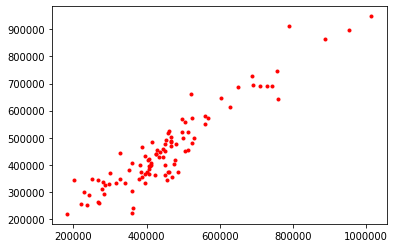

In [19]:
plt.plot(y_test, y_pred, 'r.')